In [6]:
from google.colab import files
from google.colab import drive
weather_data1 = files.upload()

Saving 기상실측데이터_1.csv to 기상실측데이터_1.csv
Saving 기상실측데이터_2.csv to 기상실측데이터_2.csv
Saving 기상예측데이터_1.csv to 기상예측데이터_1.csv
Saving 기상예측데이터_2.csv to 기상예측데이터_2.csv
Saving 제주전력시장_시장전기가격_실시간가격.csv to 제주전력시장_시장전기가격_실시간가격.csv
Saving 제주전력시장_시장전기가격_하루전가격.csv to 제주전력시장_시장전기가격_하루전가격.csv
Saving 제주전력시장_현황데이터.csv to 제주전력시장_현황데이터.csv


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

weather_real_data_1 = pd.read_csv("기상실측데이터_1.csv")
weather_real_data_2 = pd.read_csv("기상실측데이터_2.csv")
weather_predict_data_1 = pd.read_csv("기상예측데이터_1.csv")
weather_predict_data_2 = pd.read_csv("기상예측데이터_2.csv")
price_now = pd.read_csv("제주전력시장_시장전기가격_실시간가격.csv")
price_day_before = pd.read_csv("제주전력시장_시장전기가격_하루전가격.csv")
price_info = pd.read_csv("제주전력시장_현황데이터.csv")

<ipython-input-7-6f626d489cdf>:5: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_real_data_1 = pd.read_csv("기상실측데이터_1.csv")


In [8]:
from re import X
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Bidirectional, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class Data_Preprocessing():
  def __init__(self):
    pass

  def process_to_hour_interval(self, data):

    if "location" in data.columns:
      data = data.drop(["location"], axis = 1)

    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors = "coerce")
    data["ts"] = data["ts"]//3600
    hour_interval_data = data.groupby('ts').mean(numeric_only = True).reset_index()

    return hour_interval_data

  def merge(self, data1, data2):
    combined_data = pd.merge(data1, data2, on='ts')
    return combined_data

  def normalize(self, data):
    scaler = StandardScaler()
    target_data = data.drop(columns = ["ts"])
    df_normalized = pd.DataFrame(scaler.fit_transform(target_data), columns=target_data.columns, index = data.index)
    df_normalized = pd.concat([data["ts"], df_normalized], axis = 1)
    return df_normalized

  def minmaxscale(self, data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_data = pd.DataFrame(scaled_data, columns = data.columns, index = data.index)
    return scaled_data

  def standardscale(self, data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_data = pd.DataFrame(scaled_data, columns = data.columns, index = data.index)
    return scaled_data

d1 = Data_Preprocessing()
preprocessed_weather_real_data_1 = d1.process_to_hour_interval(weather_real_data_1)
preprocessed_weather_real_data_2 = d1.process_to_hour_interval(weather_real_data_2)
preprocessed_price_info = d1.process_to_hour_interval(price_info)
preprocessed_weather_real_data = pd.merge(preprocessed_weather_real_data_1, preprocessed_weather_real_data_2, on='ts')
preprocessed_weather_real_data = pd.merge(preprocessed_weather_real_data, preprocessed_price_info, on = "ts")
preprocessed_price_now = (d1.process_to_hour_interval(price_now))
preprocessed_price_day_before = (d1.process_to_hour_interval(price_day_before))
combined = pd.merge(preprocessed_weather_real_data, preprocessed_price_day_before)
combined_normalized = d1.normalize(combined)
combined_scaled = d1.minmaxscale(combined)


In [11]:
combined.to_csv("combined.csv")
from google.colab import files
files.download('combined.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
new_combined = combined_normalized.drop(["wind_spd","uv_idx", "cld_cvr", "ceiling", "pressure", "wind_dir_y", "rain","snow", "supply_power", "power_wind"], axis = 1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    new_combined.iloc[:len(new_combined)-48],
    combined["smp"][48:],
    test_size=0.2,
    random_state=0,
    shuffle=False
)

In [14]:
class OIBC():
  def __init__(self):
    self.x_train_np = x_train.values
    self.y_train_np = y_train.values
    self.x_test_np = x_test.values
    self.y_test_np = y_test.values
    self.set_shape()
    self.set_model()

  def set_shape(self):
    self.x_train_reshaped = self.x_train_np.reshape((self.x_train_np.shape[0], self.x_train_np.shape[1], 1))
    self.x_testreshaped = self.x_test_np.reshape((self.x_test_np.shape[0], self.x_test_np.shape[1], 1))

  def set_model(self):
    self.model = Sequential([
        Conv1D(filters=64, kernel_size=7,
              padding="causal",
              activation = "leaky_relu",
              input_shape=[self.x_train_reshaped.shape[1], self.x_train_reshaped.shape[2]]),
        Bidirectional(LSTM(32, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(16)),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1),
    ])

    self.loss = Huber()
    self.optimizer = Adam(0.0005)
    self.model.compile(loss = Huber(), optimizer = self.optimizer, metrics = ["mse"])

    self.earlystopping = EarlyStopping(monitor = "val_loss", patience = 10)
    self.filename = os.path.join("tmp", "checkpointer.ckpt.weights.h5")
    self.checkpoint = ModelCheckpoint(self.filename, save_weights_only = True, save_best_only = True, monitor = "val_loss", verbose = 1)


In [15]:
OIBC = OIBC()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
history = OIBC.model.fit(OIBC.x_train_np, OIBC.y_train_np, epochs=50,
                    callbacks=[OIBC.checkpoint, OIBC.earlystopping],
                    validation_data= (OIBC.x_test_np, OIBC.y_test_np))

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 129.6210 - mse: 18142.4629
Epoch 1: val_loss improved from inf to 107.37298, saving model to tmp/checkpointer.ckpt.weights.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 129.6067 - mse: 18138.2285 - val_loss: 107.3730 - val_mse: 12578.4971
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 117.4926 - mse: 14869.9473
Epoch 2: val_loss improved from 107.37298 to 90.73440, saving model to tmp/checkpointer.ckpt.weights.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 117.4674 - mse: 14863.9580 - val_loss: 90.7344 - val_mse: 9141.1689
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 100.4522 - mse: 11029.7363
Epoch 3: val_loss improved from 90.73440 to 66.46792, saving model to tmp/checkpointer.ckpt.weights.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 100.4114 - mse: 11021.5059 - val_loss: 66.4679 - val_mse: 5241.7124
Epoch 4/50
148/152 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 74.3891 - ms

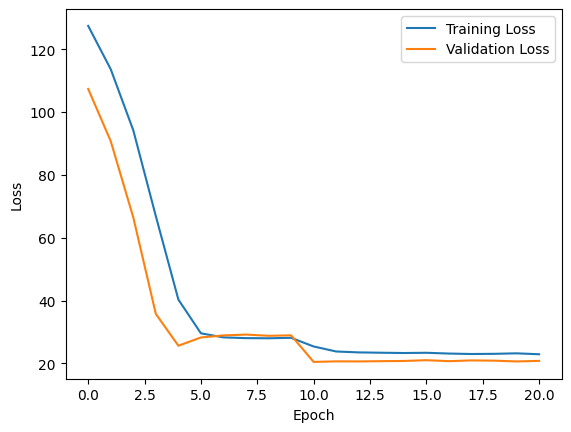

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
pred = OIBC.model.predict(OIBC.x_test_np)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


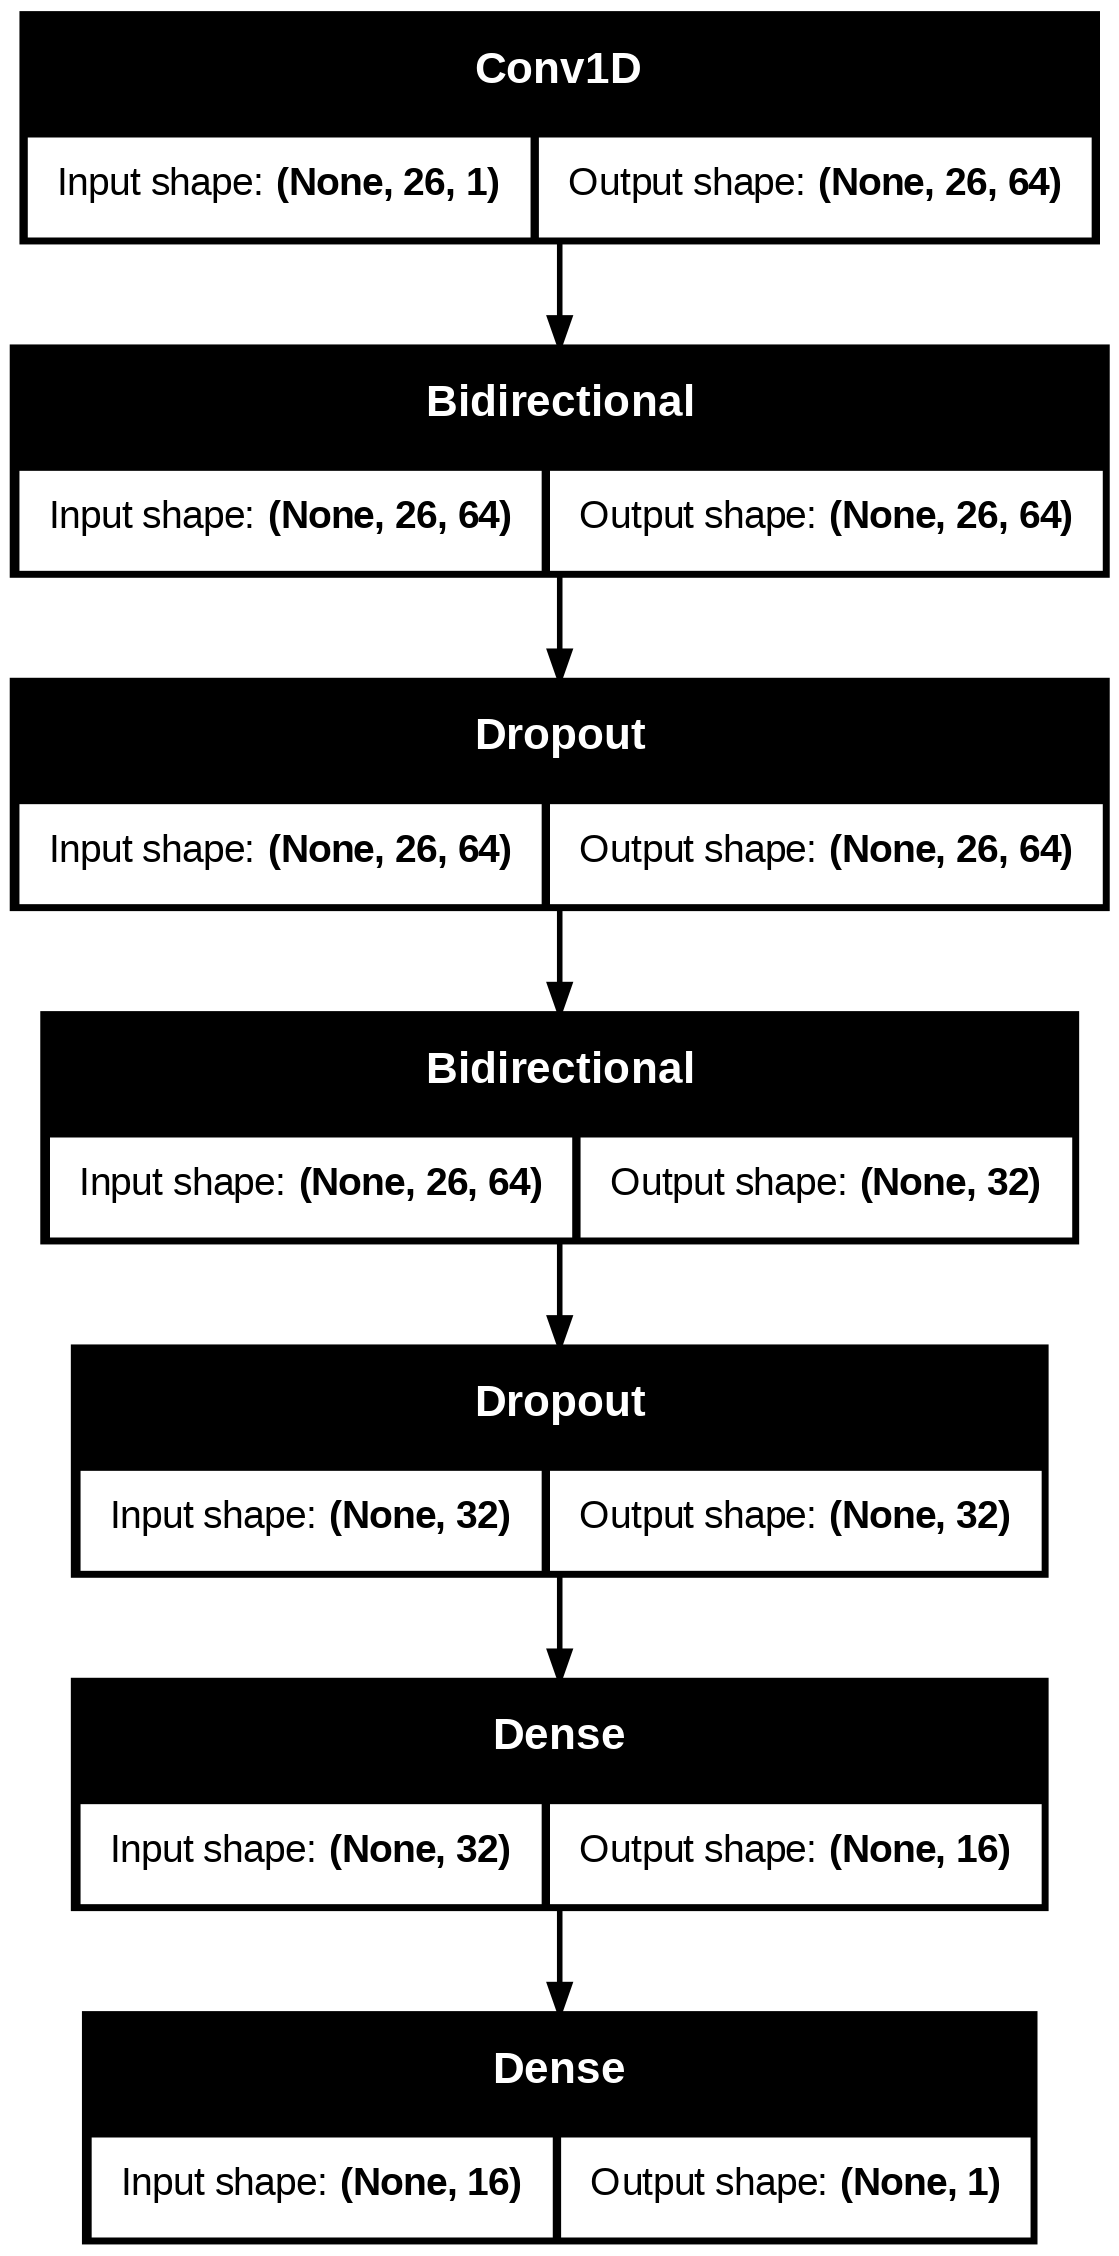

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(OIBC.model, to_file='model.png', show_shapes=True)

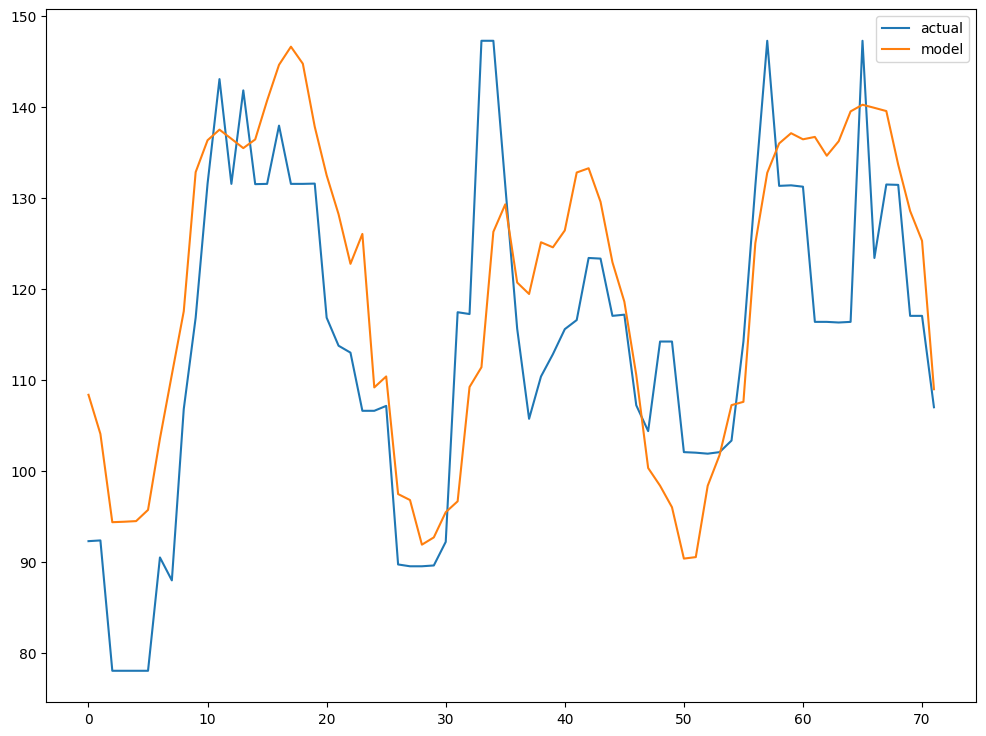

In [25]:
import matplotlib.pyplot as plt
n = -72
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test[n:]), label='actual')

plt.plot(pred[n:], label = "model")
plt.legend()
plt.show()

In [38]:
predict_target = new_combined.iloc[-48:]
predict_target_np = predict_target.values
pred_final = OIBC.model.predict(predict_target_np.reshape((predict_target_np.shape[0], predict_target_np.shape[1])))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


In [40]:
list_final = []
for i in pred_final[:, 0]:
  list_final.append(i)
print(list_final[24:])
print(len(list_final))


[103.47512, 101.93442, 96.68657, 96.382416, 96.41058, 97.11508, 98.37385, 105.39101, 114.01848, 128.58018, 125.54477, 124.33725, 123.53065, 122.02734, 122.56851, 125.02633, 132.55974, 146.40201, 140.44785, 141.57146, 141.44283, 134.6768, 132.69083, 110.666534]
48


In [41]:
import numpy as np
def calculate_measure(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast).squeeze()

    positive_index = actual > 0
    negative_index = actual <= 0

    # actual handles values ​​between 0 and -1
    actual[(actual <= 0) & (actual > -1)] = -1

    # Number of positive and negative prices
    n1 = np.sum(positive_index) + 1e-7
    n2 = np.sum(negative_index) + 1e-7

    # e1: Positive price prediction error rate
    e1 = (
        np.sum(
            np.abs(actual[positive_index] - forecast[positive_index])
            / np.abs(actual[positive_index])
        )
        / n1
    )

    # e2: Negative price prediction error rate
    e2 = (
        np.sum(
            np.abs(actual[negative_index] - forecast[negative_index])
            / np.abs(actual[negative_index])
        )
        / n2
    )

    TP = np.sum((forecast > 0) & (actual > 0))
    TN = np.sum((forecast <= 0) & (actual <= 0))
    FP = np.sum((forecast > 0) & (actual <= 0))
    FN = np.sum((forecast <= 0) & (actual > 0))

    # Accuracy Calculation
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    print(f'Accuracy: {Accuracy}')
    print(f'e1: {e1}, e2: {e2}')

    e_F = 0.2 * e1 + 0.8 * e2 - (Accuracy - 0.95)

    return e_F


In [42]:
print(list_final[24:])

[103.47512, 101.93442, 96.68657, 96.382416, 96.41058, 97.11508, 98.37385, 105.39101, 114.01848, 128.58018, 125.54477, 124.33725, 123.53065, 122.02734, 122.56851, 125.02633, 132.55974, 146.40201, 140.44785, 141.57146, 141.44283, 134.6768, 132.69083, 110.666534]
